<img src="https://github.com/djp840/MSDS_453_Public/blob/main/images/NorthwesternHeader.png?raw=1">

#### Vivian Xia


## MSDS453 - Research Assignment 02 - Classification and Clustering

Clustering methods compute a similarity (or closeness) measure, such as Euclidean distance, in order to decide whether two documents are ‘similar’ or not.  

Use the entire class corpus and do sentiment analysis for the positive and negative reviews.

Topic modeling is another way to group ‘similar’ documents into ‘clusters’. 

### Importing Packages

In [ ]:
import pandas as pd
import os
import random
import numpy as np
import pickle 
import re,string
from tabulate import tabulate

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, silhouette_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.manifold import MDS

import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models import Word2Vec,LdaMulticore, TfidfModel, CoherenceModel
from gensim import corpora
from gensim import similarities
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import corpora
from gensim.models import LsiModel,LdaModel

In [ ]:
#see if we need to import this 
import sklearn.metrics as metrics

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Mount Google Drive to Colab Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
os.chdir('/content/drive/My Drive/Colab Notebooks/MSDS453/Assignment 2/')

path_to_file='ClassCorpus_v4.csv'

###Functions

####Process Text and Create the TFIDF Matrices

In [ ]:
def remove_stop_words(in_text):
    stop_words = set(stopwords.words('english')) 
    word_tokens = word_tokenize(in_text)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    filtered_sentence = [] 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w) 

    return filtered_sentence

def apply_lemmatization(in_text):
    # Lemmatization
    lem = WordNetLemmatizer()
    word_list = nltk.word_tokenize(in_text)
    output = ' '.join([lem.lemmatize(w) for w in word_list])
    return output

In [ ]:
def clean_doc(doc): 
    # split document into individual words
    doc = ' '.join(remove_stop_words(doc))
    doc = apply_lemmatization(doc)

    tokens = doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    # lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out word "movie"
    tokens = [word for word in tokens if word != 'movie']

    return tokens

def final_processed_text(doc):
    #this is a function to join the processed text back
    ' '.join(doc)
    return doc

def tfidf(corpus, titles, ngram_range = (1,1)):
    #this is a function to created the tfidf matrix
    Tfidf=TfidfVectorizer(ngram_range= ngram_range)

    #fit the vectorizer using final processed documents.  The vectorizer requires the 
    #stiched back together document.

    TFIDF_matrix=Tfidf.fit_transform(corpus)     

    #creating datafram from TFIDF Matrix
    words = Tfidf.get_feature_names()
    matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)
    return matrix

#### K-Means

In [ ]:
def k_means(titles, tfidf_matrix, k=3):
    
    #this is a function to generate the k-means output using the tfidf matrix.  Inputs 
    #to the function include: titles of text, processed text, and desired k value. 
    #Returns dataframe indicating cluster number per document

    km = KMeans(n_clusters=k, random_state =89)
    km.fit(tfidf_matrix)
    clusters = km.labels_.tolist()

    Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
    frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])
    #dictionary to store clusters and respective titles
    cluster_title={}

    #note doc2vec clusters will not have individual words due to the vector representation
    #is based on the entire document not indvidual words. As a result, there won't be individual
    #word outputs from each cluster.   
    for i in range(k):
        temp=frame[frame['Cluster']==i]
        temp_title_list=[]
        for title in temp['Doc Name']:
            temp_title_list.append(title)
        cluster_title[i]=temp_title_list

    return cluster_title,clusters,frame

#### Plot TFIDF Matrix

In [ ]:
def plot_tfidf_matrix(cluster_title,clusters,TFIDF_matrix):
    # convert two components as we're plotting points in a two-dimensional plane
    # "precomputed" because we provide a distance matrix
    # we will also specify `random_state` so the plot is reproducible.


    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

    dist = 1 - cosine_similarity(TFIDF_matrix)

    pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

    xs, ys = pos[:, 0], pos[:, 1]


    #set up cluster names using a dict.  
    cluster_dict=cluster_title

    #create data frame that has the result of the MDS plus the cluster numbers and titles
    df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

    #group by cluster
    groups = df.groupby('label')

    fig, ax = plt.subplots(figsize=(20,20)) # set size
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    #iterate through groups to layer the plot
    #note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
    for name, group in groups:
        
        r = random.random()
        b = random.random()
        g = random.random()
        color = (r, g, b)
        
        cluster_label = group["label"].iloc[0]


        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
                label=cluster_label, color=color, 
                mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='on')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='on')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 30})      #show legend with only 1 point



#### Create Doc2Vec Matrix

In [ ]:
#functions to create doc2vec matrix
def run_doc2vec(final_processed_text, processed_text, dimension_size):
    #create doc2vec matrix
    documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
    model = Doc2Vec(documents, vector_size=dimension_size, window=3, min_count=2, workers=4)  
    
    doc2vec_df=pd.DataFrame()
    for i in range(0,len(processed_text)):
        vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
        doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)
        
    return doc2vec_df

#### Functions Classifiers

In [ ]:
def plot_roc_curve(predictions):
  
  # calculate the fpr and tpr for all thresholds of the classification
  preds = predictions[:]
  fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
  roc_auc = metrics.auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show()

In [ ]:
def classifiers(x, y, model_type, cv = 3):
  
    #can define cv value for cross validation.
    
    #function returns the train test split scores of each model.
    
    if model_type == 'svm':
        model = SVC()

    elif model_type == 'logistic':
        model = LogisticRegression()

    elif model_type == 'naive_bayes':
        model = MultinomialNB()
    
    elif model_type == 'randomforest':
        model = RandomForestClassifier()

    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    model.fit(X_train, y_train)

    
    predictions = model.predict(X_test)
    accy = accuracy_score(y_test, predictions)
    roc = roc_auc_score(y_test, predictions)

    print(model_type)
    plot_roc_curve(predictions)
    
    return model_type, accy, roc

#### Plot Confusion Matrix

In [ ]:
def plot_confusion_matrix(conf_mx):
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mx, annot=True, fmt='.2f', cbar=False, ax=ax, cmap=plt.cm.gray)
    plt.ylabel('true label')
    plt.xlabel('predicted label')

#### Latent Semantic Analysis Functions

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(lsamodel[doc_term_matrix])

    return lsamodel,dictionary,index

In [ ]:
#plot the LSA based on user defined number of topics and words
def plot_lsa(number_of_topics, words):

    model,dictionary,index=create_gensim_lsa_model(processed_text,number_of_topics,words)

    for doc in processed_text:
        vec_bow = dictionary.doc2bow(doc)
        vec_lsi = model[vec_bow]  # convert the query to LSI space
        sims = index[vec_lsi] # perform a similarity query against the corpus 

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()
    return model

#### Latent Dirichlet Allocation Functions

In [ ]:
def create_gensim_lda_model(doc_clean,number_of_topics,words):

    # Creating the term dictionary of our courpus, where every unique term is assigned 
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LSA model
    ldamodel = LdaModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)
    # train model
    print(ldamodel.print_topics(num_topics=number_of_topics, num_words=words))
    index = similarities.MatrixSimilarity(ldamodel[doc_term_matrix])
    return ldamodel,dictionary,index,doc_term_matrix

In [ ]:
#plot the LDA based on user defined number of topics and words
def plot_lda(number_of_topics, words):

    model2,dictionary2,index2,doctermmatrix2=create_gensim_lda_model( processed_text,number_of_topics,words)


    for doc in processed_text:
        vec_bow2 = dictionary2.doc2bow(doc)
        vec2 = model2[vec_bow2]  # convert the query to embedded space
        sims2 = index2[vec2]  # perform a similarity query against the corpus
        #print(list(enumerate(sims2)))  

    fig, ax = plt.subplots(figsize=(30, 10))
    cax = ax.matshow(index2, interpolation='nearest')
    ax.grid(True)
    plt.xticks(range(len(processed_text)), titles, rotation=90);
    plt.yticks(range(len(processed_text)), titles);
    fig.colorbar(cax)
    plt.show()

### Load Data For Analysis

In [ ]:
#read in class corpus csv into python
data=pd.read_csv(path_to_file)

In [ ]:
data.head(10)

Doc_ID          DSI_Title  ... Review Type (pos or neg) Movie Title
0       0   HAG_Doc1_Frozen2  ...                 Positive    Frozen_2
1       1   HAG_Doc2_Frozen2  ...                 Positive    Frozen_2
2       2   HAG_Doc3_Frozen2  ...                 Positive    Frozen_2
3       3   HAG_Doc4_Frozen2  ...                 Positive    Frozen_2
4       4   HAG_Doc5_Frozen2  ...                 Positive    Frozen_2
5       5   HAG_Doc6_Frozen2  ...                 Negative    Frozen_2
6       6   HAG_Doc7_Frozen2  ...                 Negative    Frozen_2
7       7   HAG_Doc8_Frozen2  ...                 Negative    Frozen_2
8       8   HAG_Doc9_Frozen2  ...                 Negative    Frozen_2
9       9  HAG_Doc10_Frozen2  ...                 Negative    Frozen_2

[10 rows x 8 columns]

### Dataframe Store the Processed Text and Tokenized text

In [ ]:
#adding two columns to the dataframe to store the processed text and tokenized text
data['processed_text'] = data['Text'].apply(lambda x: clean_doc(x))


#creating final processed text variables for matrix creation
final_processed_text = [' '.join(x) for x in data['processed_text'].tolist()]
titles = data['DSI_Title'].tolist()
processed_text = data['processed_text'].tolist()

#generate tfidf for analysis
tfidf_matrix = tfidf(final_processed_text, titles, ngram_range = (1,1))

## Part 1: Clustering


### Implementation and Plot Elbow Method

In [ ]:
K = list(range(2, 28, 2))
Sum_of_squared_distances = []

for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters, random_state=89)
 kmeans.fit(tfidf_matrix)
 Sum_of_squared_distances.append(kmeans.inertia_)

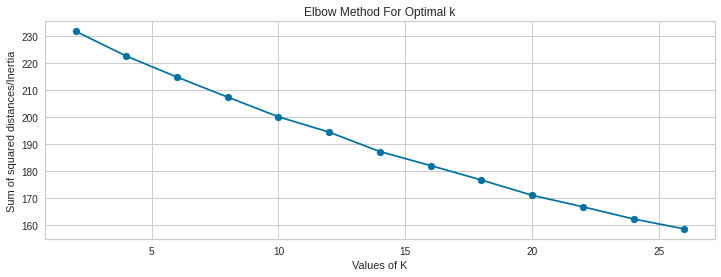

In [ ]:
plt.figure(figsize=(12, 4))
plt.scatter(K, Sum_of_squared_distances)
plt.plot(K, Sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

### Implementation and Plot Silhouette Score

In [ ]:
k_list = list(range(2, 28, 2))
sil_scores = []

for k in k_list:
    km = KMeans(n_clusters=k, random_state=89)
    km.fit(tfidf_matrix)
    labels = km.labels_.tolist()
    score = silhouette_score(tfidf_matrix, labels)
    sil_scores.append(score)

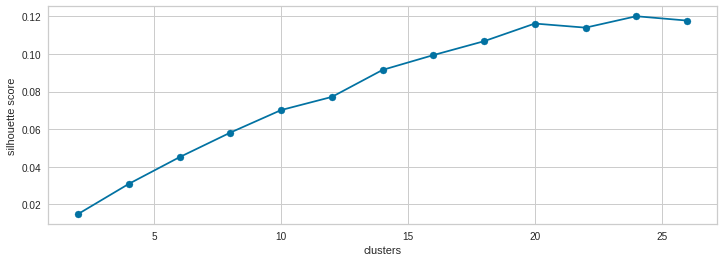

In [ ]:
plt.figure(figsize=(12, 4))
plt.scatter(k_list, sil_scores)
plt.plot(k_list, sil_scores)
plt.xlabel("clusters")
plt.ylabel("silhouette score")
plt.show()

### Execute K-means Clustering (k=20)

In [ ]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=20)

In [ ]:
cluster_title

{0: ['CEC_Doc1_RedNotice',
  'CEC_Doc2_RedNotice',
  'CEC_Doc3_RedNotice',
  'CEC_Doc4_RedNotice',
  'CEC_Doc5_RedNotice',
  'CEC_Doc6_RedNotice',
  'CEC_Doc7_RedNotice',
  'CEC_Doc8_RedNotice',
  'CEC_Doc9_RedNotice',
  'CEC_Doc10_RedNotice',
  'SMM_Doc1_RedNotice',
  'SMM_Doc2_RedNotice',
  'SMM_Doc3_RedNotice',
  'SMM_Doc4_RedNotice',
  'SMM_Doc5_RedNotice',
  'SMM_Doc6_RedNotice',
  'SMM_Doc7_RedNotice',
  'SMM_Doc8_RedNotice',
  'SMM_Doc9_RedNotice',
  'SMM_Doc10_RedNotice'],
 1: ['AAT_Doc7_TheMatrixResurrecton',
  'BMI_Doc1_Hereditary',
  'BMI_Doc2_Hereditary',
  'BMI_Doc3_Hereditary',
  'BMI_Doc4_Hereditary',
  'BMI_Doc5_Hereditary',
  'BMI_Doc6_Hereditary',
  'BMI_Doc7_Hereditary',
  'BMI_Doc8_Hereditary',
  'BMI_Doc9_Hereditary',
  'BMI_Doc10_Hereditary',
  'MRG_Doc1_Poltergeist',
  'MRG_Doc2_Poltergeist',
  'MRG_Doc3_Poltergeist',
  'MRG_Doc4_Poltergeist',
  'MRG_Doc5_Poltergeist',
  'MRG_Doc6_Poltergeist',
  'MRG_Doc7_Poltergeist',
  'MRG_Doc8_Poltergeist',
  'MRG_Doc9_Polte

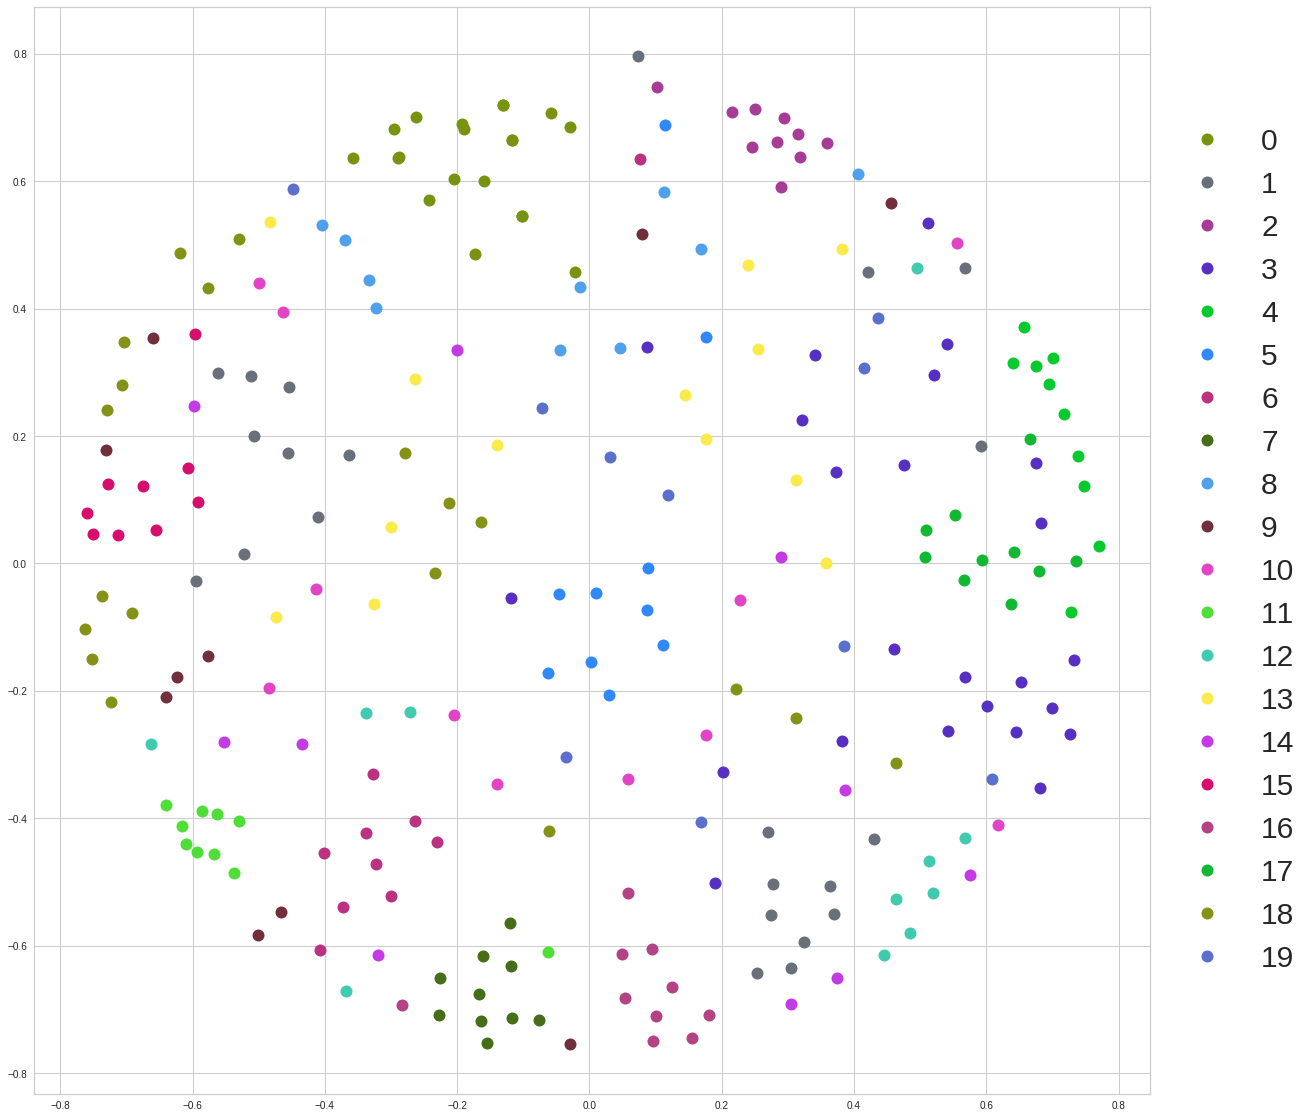

In [ ]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Execute K-means Clustering (k=24 for the 24 movies)

Because there are two sets of Red Notice documents, k = 24 instead of 25. 

In [ ]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=24)

In [ ]:
cluster_title

{0: ['VXL_Doc1_GuardiansOfTheGalaxy',
  'VXL_Doc2_GuardiansOfTheGalaxy',
  'VXL_Doc3_GuardiansOfTheGalaxy',
  'VXL_Doc4_GuardiansOfTheGalaxy',
  'VXL_Doc5_GuardiansOfTheGalaxy',
  'VXL_Doc6_GuardiansOfTheGalaxy',
  'VXL_Doc7_GuardiansOfTheGalaxy',
  'VXL_Doc8_GuardiansOfTheGalaxy',
  'VXL_Doc9_GuardiansOfTheGalaxy',
  'VXL_Doc10_GuardiansOfTheGalaxy'],
 1: ['CAA_Doc1_Cruella',
  'CAA_Doc2_Cruella',
  'CAA_Doc3_Cruella',
  'CAA_Doc4_Cruella',
  'CAA_Doc5_Cruella',
  'CAA_Doc6_Cruella',
  'CAA_Doc7_Cruella',
  'CAA_Doc8_Cruella',
  'CAA_Doc9_Cruella',
  'CAA_Doc10_Cruella'],
 2: ['AAT_Doc1_TheMatrixResurrecton',
  'AAT_Doc2_TheMatrixResurrecton',
  'AAT_Doc3_TheMatrixResurrecton',
  'AAT_Doc5_TheMatrixResurrecton',
  'AAT_Doc6_TheMatrixResurrecton',
  'AAT_Doc7_TheMatrixResurrecton',
  'AAT_Doc8_TheMatrixResurrecton',
  'AAT_Doc9_TheMatrixResurrecton',
  'AAT_Doc10_TheMatrixResurrecton',
  'IKL_Doc1_PiratesOfTheCaribbean:TheCurseOfTheBlackPearl',
  'IKL_Doc1_PiratesOfTheCaribbean:TheCurs

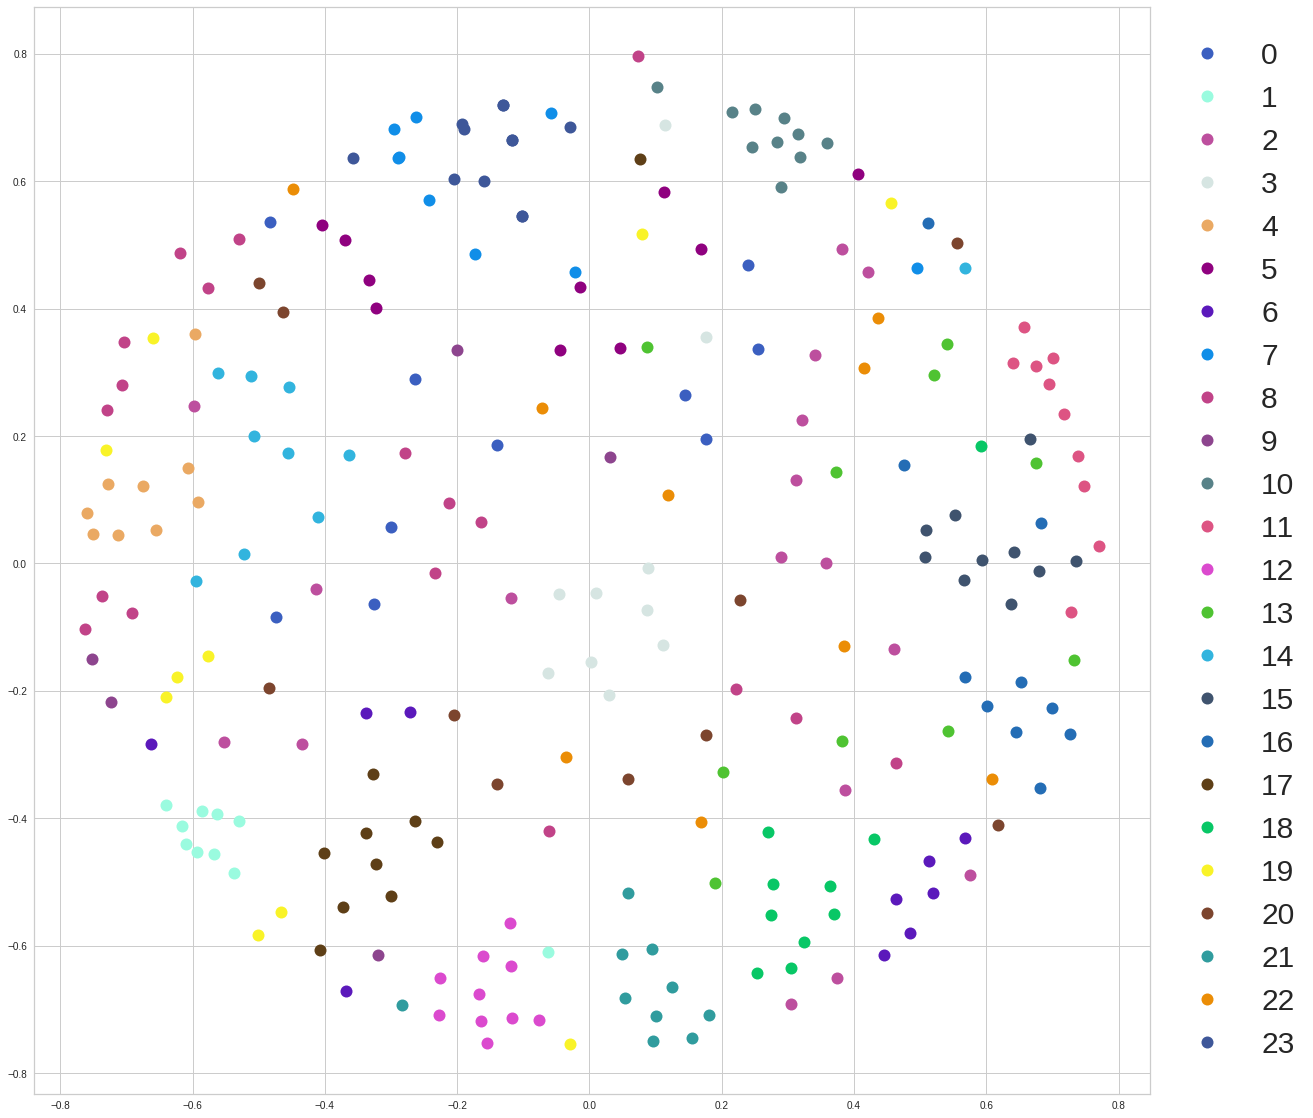

In [ ]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

### Execute K-means Clustering (k=4 for the 4 genres)

In [ ]:
cluster_title,clusters,k_means_df = k_means(titles, tfidf_matrix, k=4)

In [ ]:
cluster_title

{0: ['CEC_Doc1_RedNotice',
  'CEC_Doc2_RedNotice',
  'CEC_Doc3_RedNotice',
  'CEC_Doc4_RedNotice',
  'CEC_Doc5_RedNotice',
  'CEC_Doc6_RedNotice',
  'CEC_Doc7_RedNotice',
  'CEC_Doc8_RedNotice',
  'CEC_Doc9_RedNotice',
  'CEC_Doc10_RedNotice',
  'SMM_Doc1_RedNotice',
  'SMM_Doc3_RedNotice',
  'SMM_Doc4_RedNotice',
  'SMM_Doc5_RedNotice',
  'SMM_Doc6_RedNotice',
  'SMM_Doc7_RedNotice',
  'SMM_Doc8_RedNotice',
  'SMM_Doc9_RedNotice',
  'SMM_Doc10_RedNotice'],
 1: ['HAG_Doc1_Frozen2',
  'HAG_Doc2_Frozen2',
  'HAG_Doc3_Frozen2',
  'HAG_Doc4_Frozen2',
  'HAG_Doc5_Frozen2',
  'HAG_Doc6_Frozen2',
  'HAG_Doc7_Frozen2',
  'HAG_Doc8_Frozen2',
  'HAG_Doc9_Frozen2',
  'HAG_Doc10_Frozen2',
  'AAT_Doc1_TheMatrixResurrecton',
  'AAT_Doc2_TheMatrixResurrecton',
  'AAT_Doc3_TheMatrixResurrecton',
  'AAT_Doc4_TheMatrixResurrecton',
  'AAT_Doc5_TheMatrixResurrecton',
  'AAT_Doc6_TheMatrixResurrecton',
  'AAT_Doc7_TheMatrixResurrecton',
  'AAT_Doc8_TheMatrixResurrecton',
  'AAT_Doc9_TheMatrixResurrecton',

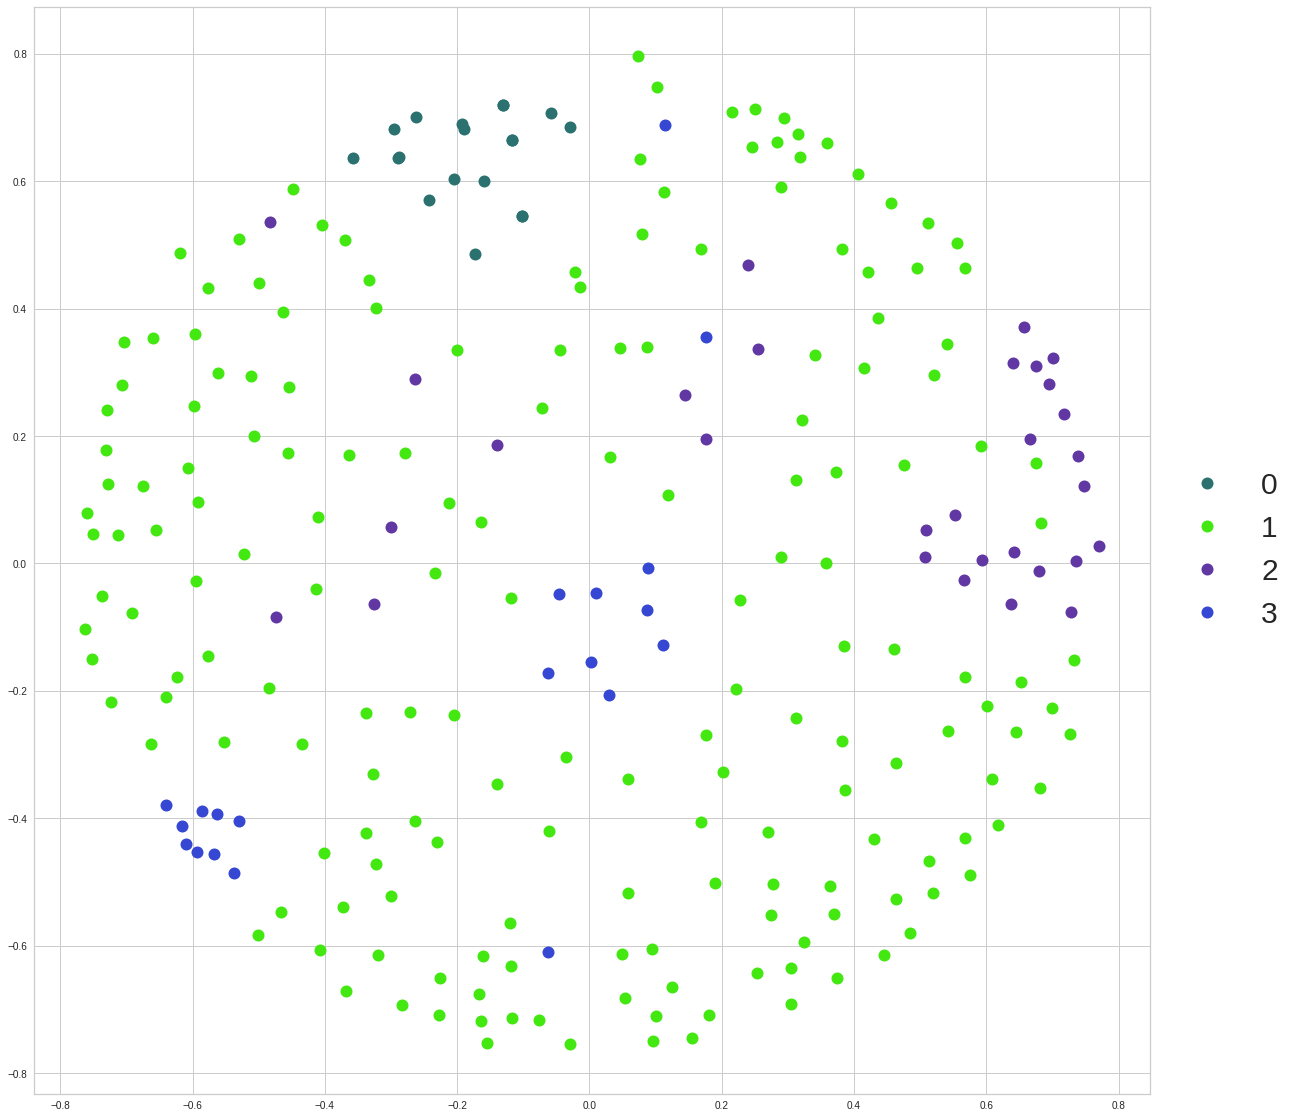

In [ ]:
plot_tfidf_matrix(cluster_title,clusters,tfidf_matrix)

## Part 2: Sentiment Analysis
Demonstrate supervised learning methods.

### Apply Labels 

In [ ]:
labels = data['Review Type (pos or neg)'].apply(lambda x: 0 if x.lower().split(' ')[0] == 'negative' else 1)
print(labels)

0      1
1      1
2      1
3      1
4      1
      ..
244    0
245    0
246    0
247    0
248    0
Name: Review Type (pos or neg), Length: 249, dtype: int64


### Predict Sentiment using td-idf vectorization

svm


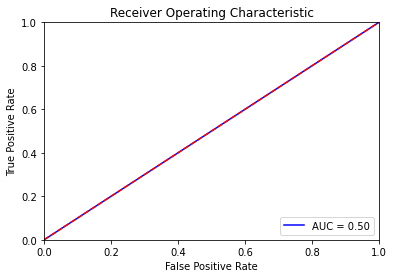

logistic


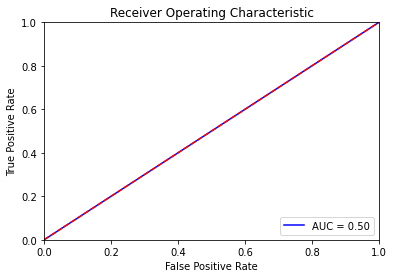

naive_bayes


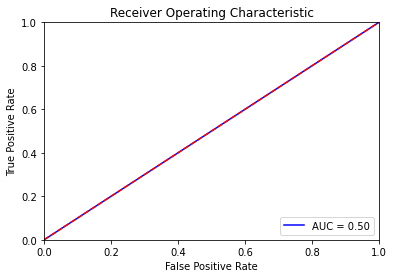

randomforest


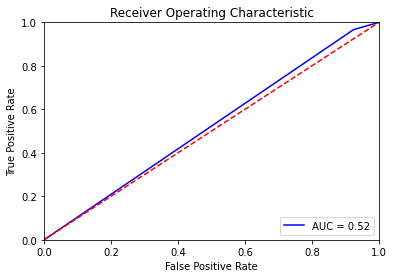

In [ ]:
classifer_accuracy = [] 

classifer_accuracy.append(classifiers(tfidf_matrix, labels, 'svm'))
classifer_accuracy.append(classifiers(tfidf_matrix, labels, 'logistic'))
classifer_accuracy.append(classifiers(tfidf_matrix, labels, 'naive_bayes'))
classifer_accuracy.append(classifiers(tfidf_matrix, labels, 'randomforest'))

In [ ]:
print(tabulate(classifer_accuracy, headers=["Model", "Accuracy","ROC AUC Score"], tablefmt="fancy_grid", floatfmt=".2f"))

╒══════════════╤════════════╤═════════════════╕
│ Model        │   Accuracy │   ROC AUC Score │
╞══════════════╪════════════╪═════════════════╡
│ svm          │       0.36 │            0.50 │
├──────────────┼────────────┼─────────────────┤
│ logistic     │       0.36 │            0.50 │
├──────────────┼────────────┼─────────────────┤
│ naive_bayes  │       0.36 │            0.50 │
├──────────────┼────────────┼─────────────────┤
│ randomforest │       0.40 │            0.52 │
╘══════════════╧════════════╧═════════════════╛


#### Confusion Matrix

In [ ]:
model = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, labels, test_size=0.33, random_state=42)
model.fit(x_train, y_train)

pred = model.predict(x_test)

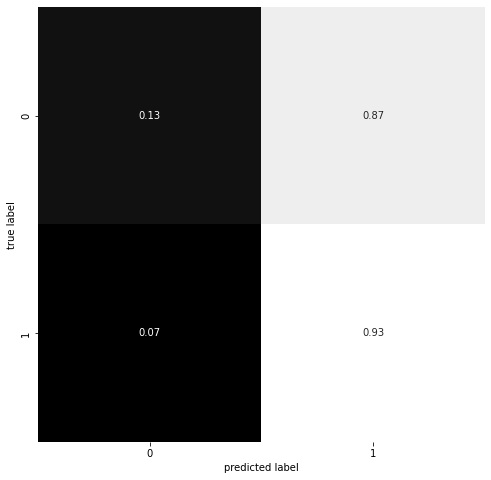

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

### Predict Sentiment using Doc2Vec

In [ ]:
doc2vec_df = run_doc2vec(final_processed_text, processed_text, 200)

svm


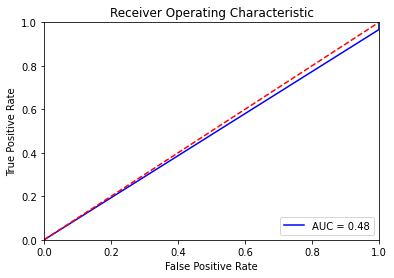

logistic


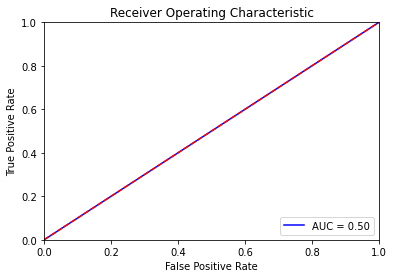

randomforest


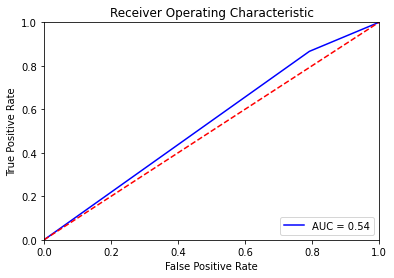

In [ ]:
classifer_accuracy = [] 

classifer_accuracy.append(classifiers(doc2vec_df, labels, 'svm'))
classifer_accuracy.append(classifiers(doc2vec_df, labels, 'logistic'))
classifer_accuracy.append(classifiers(doc2vec_df, labels, 'randomforest'))

In [ ]:
print(tabulate(classifer_accuracy, headers=["Model", "Accuracy","ROC AUC Score"], tablefmt="fancy_grid", floatfmt=".2f"))

╒══════════════╤════════════╤═════════════════╕
│ Model        │   Accuracy │   ROC AUC Score │
╞══════════════╪════════════╪═════════════════╡
│ svm          │       0.35 │            0.48 │
├──────────────┼────────────┼─────────────────┤
│ logistic     │       0.36 │            0.50 │
├──────────────┼────────────┼─────────────────┤
│ randomforest │       0.45 │            0.54 │
╘══════════════╧════════════╧═════════════════╛


#### Confusion Matrix

In [ ]:
model = RandomForestClassifier()

x_train, x_test, y_train, y_test = train_test_split(doc2vec_df, labels, test_size=0.33, random_state=42)
model.fit(x_train, y_train)

pred = model.predict(x_test)

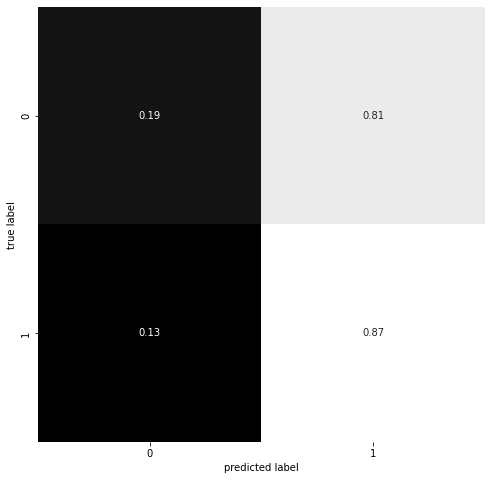

In [ ]:
conf_mx = confusion_matrix(y_test, pred)
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = np.round((conf_mx / row_sums), 2)

plot_confusion_matrix(norm_conf_mx)

## Part 3: Topic Modeling

### Latent Semantic Analysis

#### Plotting 2 topics and 10 words

[(0, '0.236*"character" + 0.197*"story" + 0.164*"first" + 0.152*"cruella" + 0.141*"family" + 0.136*"thing" + 0.126*"there" + 0.124*"would" + 0.122*"scene" + 0.117*"another"'), (1, '0.769*"cruella" + 0.190*"baroness" + 0.156*"estella" + 0.127*"woman" + 0.126*"disney" + 0.122*"character" + 0.115*"villain" + 0.112*"stone" + 0.104*"fashion" + 0.101*"dalmatians"')]


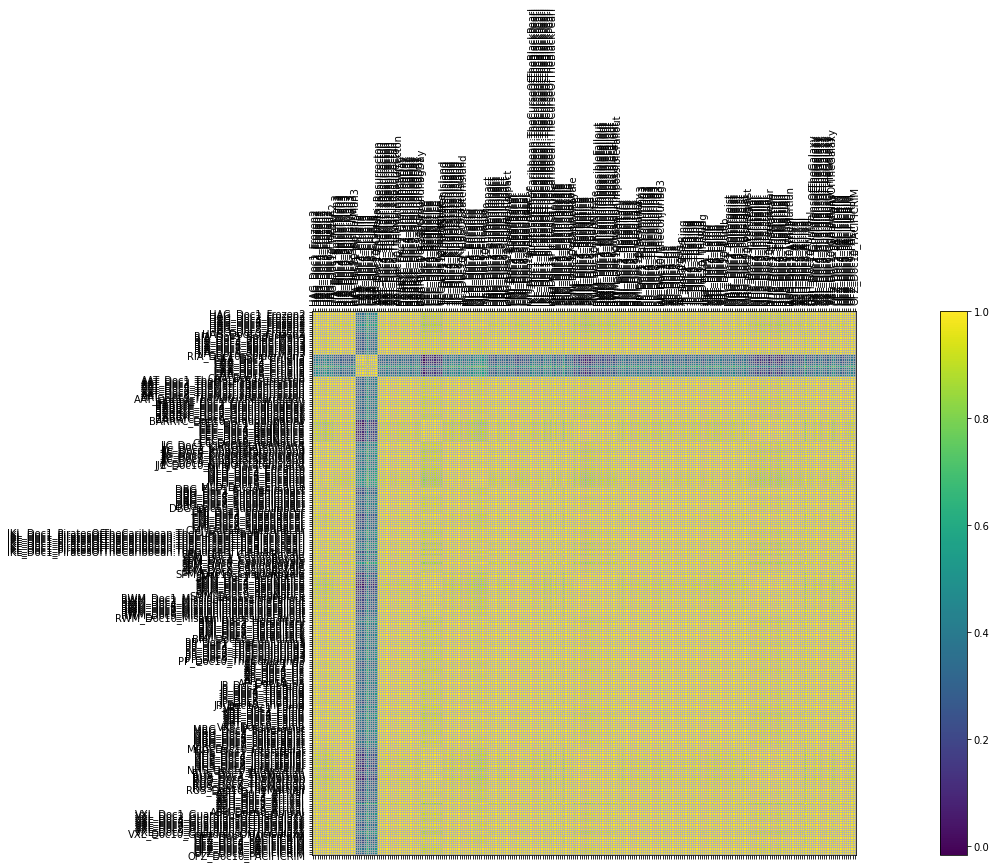

In [ ]:
lsa_model_2topic_10words = plot_lsa(2, 10)

#### Plotting 4 topics and 10 words

[(0, '0.236*"character" + 0.197*"story" + 0.164*"first" + 0.152*"cruella" + 0.141*"family" + 0.136*"thing" + 0.126*"there" + 0.124*"would" + 0.122*"scene" + 0.117*"another"'), (1, '-0.769*"cruella" + -0.190*"baroness" + -0.156*"estella" + -0.127*"woman" + -0.126*"disney" + -0.122*"character" + -0.115*"villain" + -0.112*"stone" + -0.104*"fashion" + -0.101*"dalmatians"'), (2, '0.335*"notice" + 0.326*"johnson" + 0.310*"reynolds" + -0.250*"family" + 0.213*"gadot" + 0.200*"booth" + 0.192*"hartley" + 0.189*"thurber" + -0.122*"horror" + 0.118*"action"'), (3, '-0.534*"harry" + -0.306*"eastwood" + -0.248*"spiderman" + -0.194*"dirty" + -0.187*"peter" + 0.162*"interstellar" + -0.151*"impact" + -0.150*"sudden" + 0.150*"space" + 0.137*"family"')]


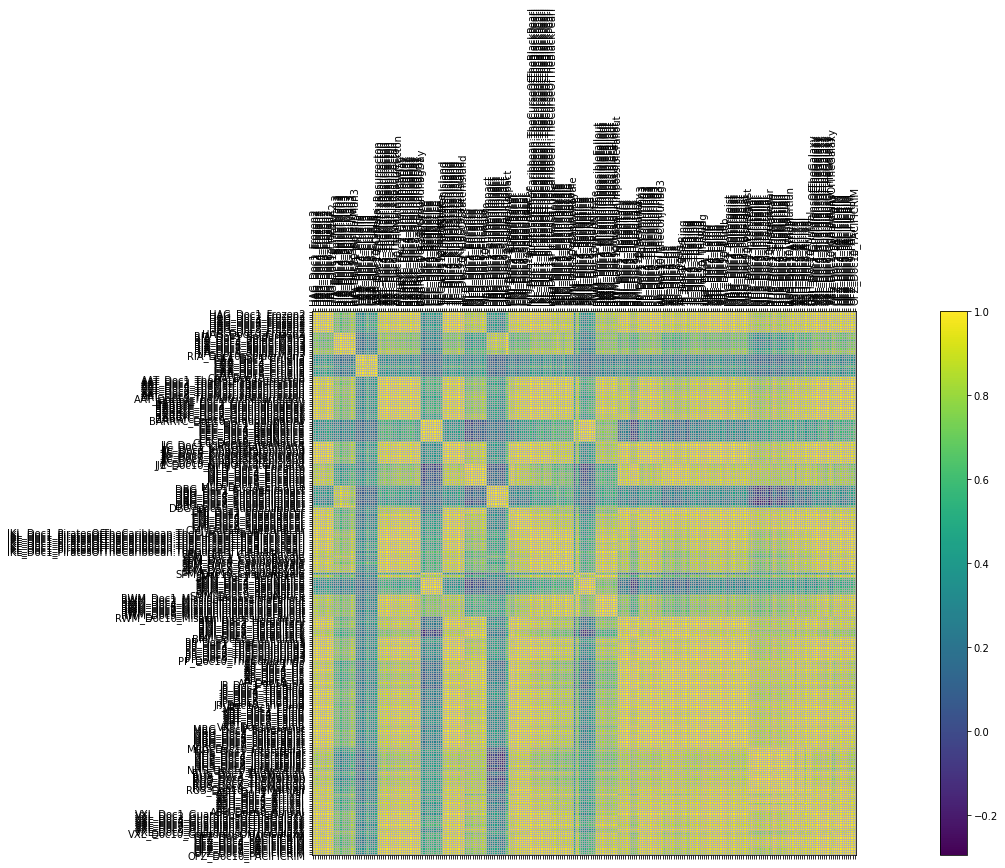

In [ ]:
lsa_model_4topic_10words = plot_lsa(4, 10)


#### Plotting 10 topics and 10 words

[(0, '0.236*"character" + 0.197*"story" + 0.164*"first" + 0.152*"cruella" + 0.141*"family" + 0.136*"thing" + 0.126*"there" + 0.124*"would" + 0.122*"scene" + 0.117*"another"'), (1, '0.769*"cruella" + 0.190*"baroness" + 0.156*"estella" + 0.127*"woman" + 0.126*"disney" + 0.122*"character" + 0.115*"villain" + 0.112*"stone" + 0.104*"fashion" + 0.101*"dalmatians"'), (2, '0.335*"notice" + 0.326*"johnson" + 0.310*"reynolds" + -0.250*"family" + 0.213*"gadot" + 0.200*"booth" + 0.192*"hartley" + 0.189*"thurber" + -0.122*"horror" + 0.118*"action"'), (3, '0.534*"harry" + 0.306*"eastwood" + 0.248*"spiderman" + 0.194*"dirty" + 0.187*"peter" + -0.162*"interstellar" + 0.151*"impact" + 0.150*"sudden" + -0.150*"space" + -0.136*"family"'), (4, '-0.266*"interstellar" + -0.252*"space" + 0.208*"horror" + -0.175*"nolan" + 0.173*"family" + 0.149*"conjuring" + 0.145*"johnson" + 0.141*"devil" + -0.140*"mission" + -0.136*"planet"'), (5, '0.459*"spiderman" + 0.353*"peter" + -0.343*"harry" + -0.251*"eastwood" + 0.2

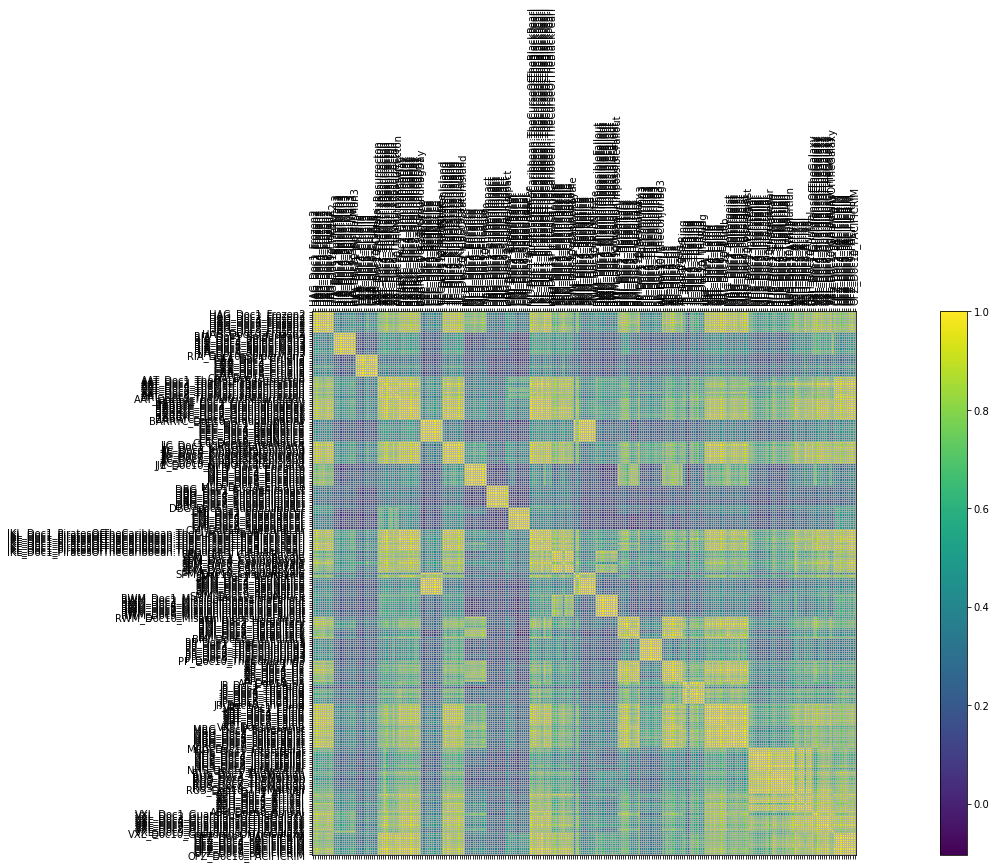

In [ ]:
lsa_model_10topic_10words = plot_lsa(10, 10)

#### Compare LSA Model Coherence

In [ ]:
topics = [2, 4, 10]
coherence_values = []
for t in topics:
    lsamodel,dictionary,index = create_gensim_lsa_model(processed_text,t,10)


    coherence_model_lsa = CoherenceModel(model=lsamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lsa = coherence_model_lsa.get_coherence()
    coherence_values.append(coherence_lsa)

    
coherence ={'2 topic 10 words':coherence_values[0],
           '4 topic 10 words': coherence_values[1],
           '10 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.236*"character" + 0.197*"story" + 0.164*"first" + 0.152*"cruella" + 0.141*"family" + 0.136*"thing" + 0.126*"there" + 0.124*"would" + 0.122*"scene" + 0.117*"another"'), (1, '0.769*"cruella" + 0.190*"baroness" + 0.156*"estella" + 0.127*"woman" + 0.126*"disney" + 0.122*"character" + 0.115*"villain" + 0.112*"stone" + 0.104*"fashion" + 0.101*"dalmatians"')]
[(0, '0.236*"character" + 0.197*"story" + 0.164*"first" + 0.152*"cruella" + 0.141*"family" + 0.136*"thing" + 0.126*"there" + 0.124*"would" + 0.122*"scene" + 0.117*"another"'), (1, '0.769*"cruella" + 0.190*"baroness" + 0.156*"estella" + 0.127*"woman" + 0.126*"disney" + 0.122*"character" + 0.115*"villain" + 0.112*"stone" + 0.104*"fashion" + 0.101*"dalmatians"'), (2, '0.335*"notice" + 0.326*"johnson" + 0.310*"reynolds" + -0.249*"family" + 0.213*"gadot" + 0.200*"booth" + 0.192*"hartley" + 0.189*"thurber" + -0.122*"horror" + 0.118*"action"'), (3, '0.534*"harry" + 0.306*"eastwood" + 0.248*"spiderman" + 0.194*"dirty" + 0.187*"peter" + -

### Latent Dirichlet Allocation

#### Plotting 2 topics and 10 words

[(0, '0.005*"character" + 0.004*"story" + 0.004*"first" + 0.003*"thing" + 0.003*"would" + 0.003*"there" + 0.003*"another" + 0.003*"world" + 0.003*"family" + 0.002*"little"'), (1, '0.004*"character" + 0.004*"story" + 0.003*"family" + 0.003*"first" + 0.003*"scene" + 0.003*"action" + 0.002*"something" + 0.002*"never" + 0.002*"would" + 0.002*"there"')]


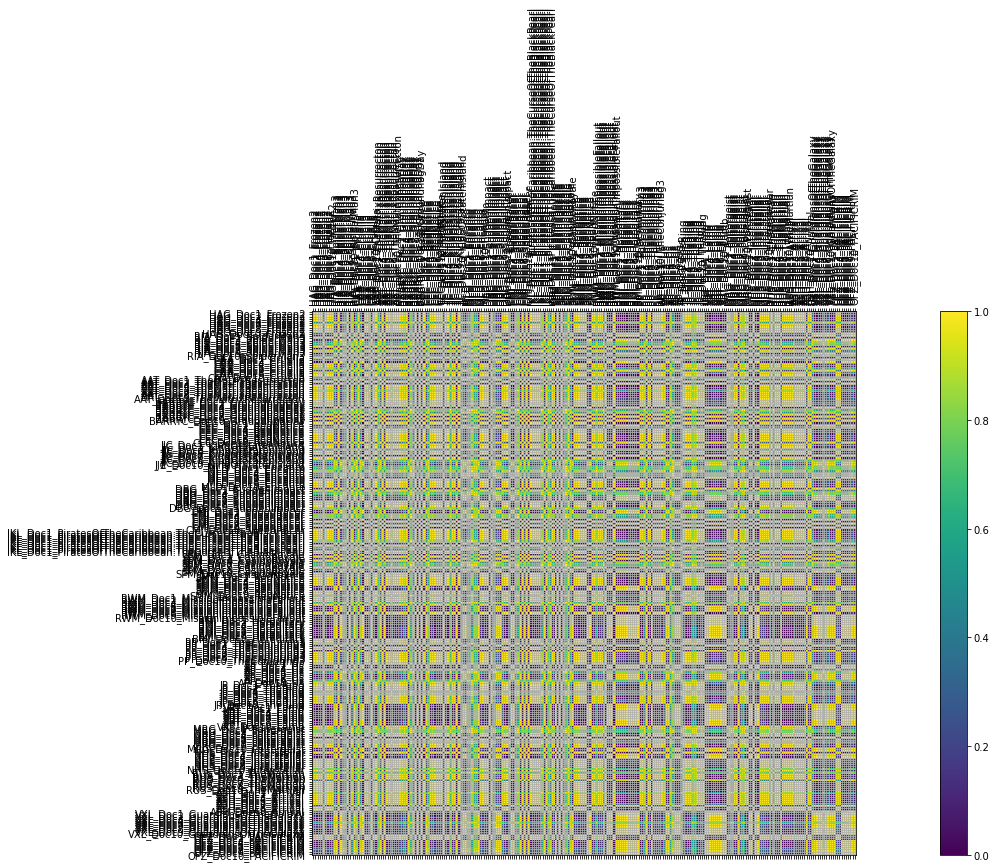

In [ ]:
lda_model_2topic_10words = plot_lda(2,10)

#### Plotting 4 topics and 10 words

[(0, '0.005*"character" + 0.004*"story" + 0.003*"scene" + 0.003*"family" + 0.003*"there" + 0.003*"would" + 0.003*"first" + 0.003*"world" + 0.002*"little" + 0.002*"never"'), (1, '0.004*"first" + 0.003*"story" + 0.003*"family" + 0.003*"character" + 0.003*"world" + 0.003*"action" + 0.002*"around" + 0.002*"something" + 0.002*"still" + 0.002*"there"'), (2, '0.005*"character" + 0.003*"story" + 0.003*"thing" + 0.003*"first" + 0.003*"horror" + 0.003*"family" + 0.002*"never" + 0.002*"would" + 0.002*"there" + 0.002*"world"'), (3, '0.005*"character" + 0.005*"story" + 0.004*"thing" + 0.003*"action" + 0.003*"first" + 0.003*"would" + 0.003*"cruella" + 0.003*"family" + 0.003*"little" + 0.003*"still"')]


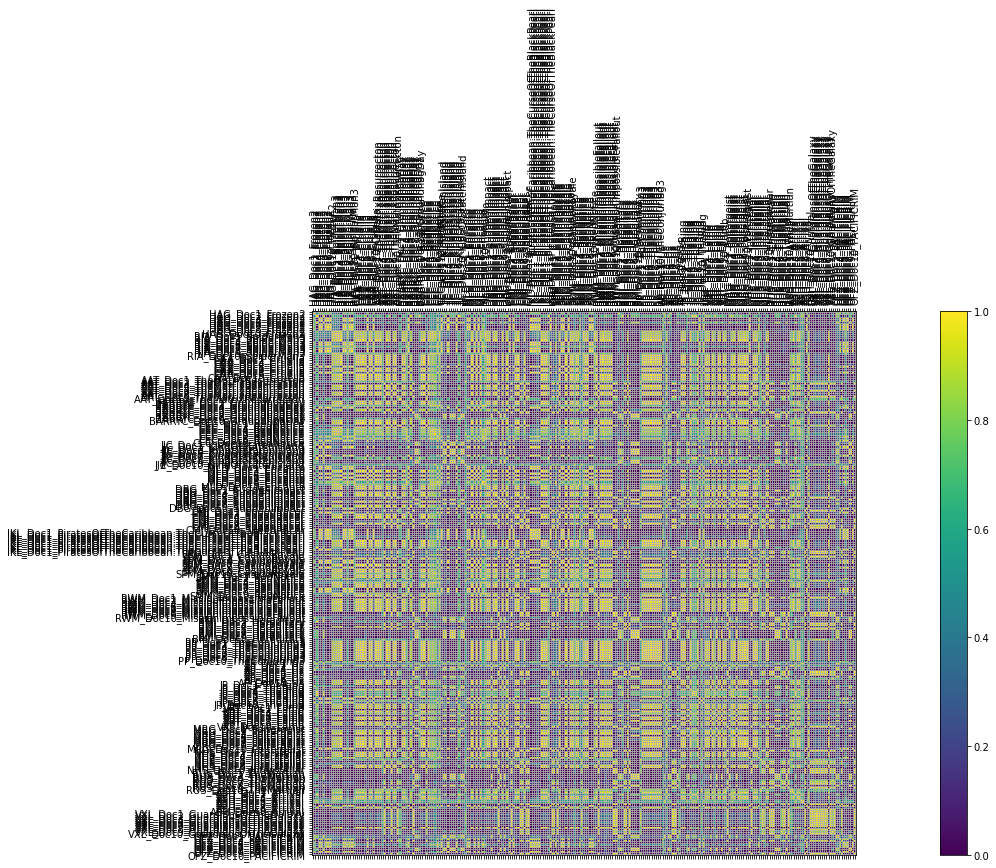

In [ ]:
lda_model_4topic_10words = plot_lda(4,10)

#### Plotting 10 topics and 10 words

[(0, '0.004*"first" + 0.004*"character" + 0.003*"would" + 0.003*"story" + 0.003*"something" + 0.002*"cruella" + 0.002*"never" + 0.002*"harry" + 0.002*"still" + 0.002*"scene"'), (1, '0.006*"character" + 0.005*"family" + 0.004*"thing" + 0.004*"story" + 0.003*"world" + 0.003*"little" + 0.003*"first" + 0.003*"there" + 0.003*"people" + 0.003*"peter"'), (2, '0.005*"character" + 0.003*"story" + 0.003*"cruella" + 0.003*"another" + 0.002*"never" + 0.002*"family" + 0.002*"first" + 0.002*"scene" + 0.002*"would" + 0.002*"original"'), (3, '0.005*"cruella" + 0.004*"story" + 0.003*"character" + 0.003*"would" + 0.003*"first" + 0.003*"family" + 0.003*"there" + 0.002*"action" + 0.002*"world" + 0.002*"around"'), (4, '0.005*"character" + 0.004*"world" + 0.003*"story" + 0.003*"would" + 0.003*"scene" + 0.003*"family" + 0.003*"first" + 0.003*"thing" + 0.002*"johnson" + 0.002*"cruella"'), (5, '0.004*"character" + 0.004*"story" + 0.004*"first" + 0.003*"action" + 0.003*"would" + 0.003*"harry" + 0.003*"there" + 

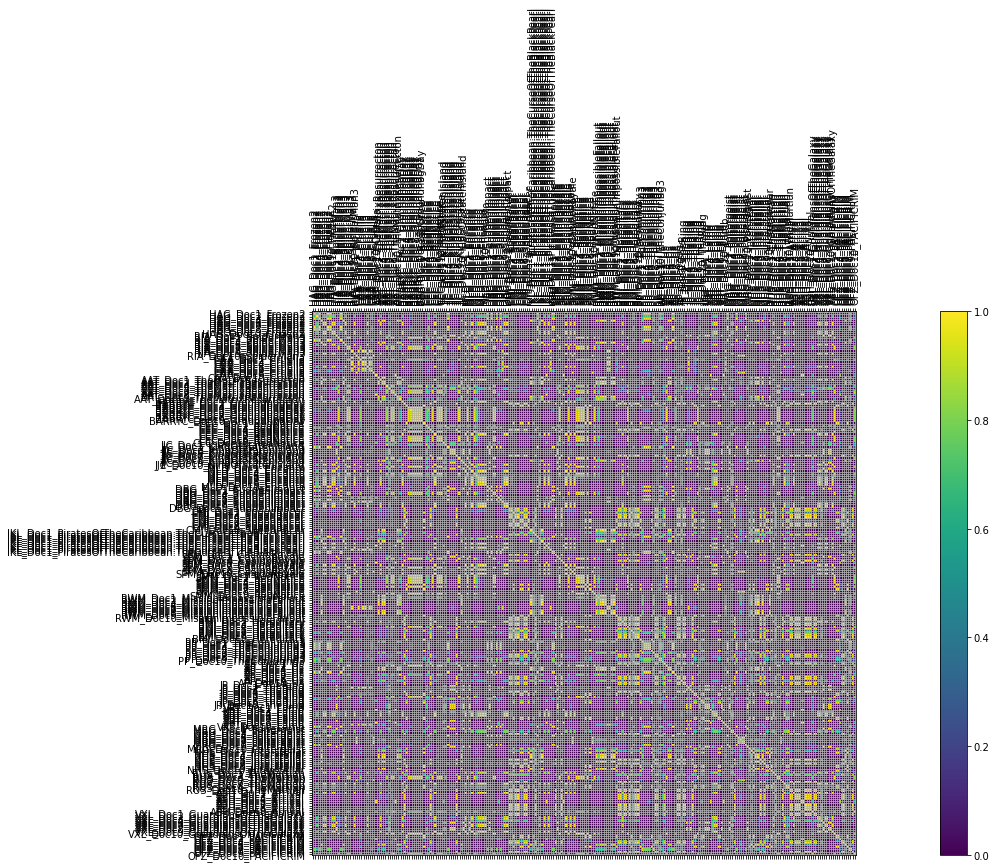

In [ ]:
lda_model_10topic_10words = plot_lda(10,10)

#### Compare LSA Model Coherence

In [ ]:
topics = [2, 4, 10]
coherence_values = []
for t in topics:
    ldamodel,dictionary,index, matrix = create_gensim_lda_model(processed_text,t,10)


    coherence_model_lda = CoherenceModel(model=ldamodel, dictionary=dictionary, texts=processed_text, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

    
coherence ={'2 topic 10 words':coherence_values[0],
           '4 topic 10 words': coherence_values[1],
           '10 topic 10 words':coherence_values[2]}   

print(coherence)

[(0, '0.004*"family" + 0.004*"story" + 0.004*"character" + 0.003*"thing" + 0.003*"there" + 0.003*"first" + 0.002*"something" + 0.002*"action" + 0.002*"another" + 0.002*"little"'), (1, '0.005*"character" + 0.004*"first" + 0.004*"story" + 0.003*"would" + 0.003*"world" + 0.003*"scene" + 0.003*"thing" + 0.002*"action" + 0.002*"never" + 0.002*"there"')]
[(0, '0.005*"character" + 0.004*"story" + 0.004*"family" + 0.003*"first" + 0.003*"thing" + 0.003*"world" + 0.003*"would" + 0.003*"there" + 0.003*"scene" + 0.003*"little"'), (1, '0.004*"character" + 0.003*"first" + 0.003*"story" + 0.003*"action" + 0.003*"people" + 0.003*"never" + 0.003*"would" + 0.002*"scene" + 0.002*"world" + 0.002*"another"'), (2, '0.004*"character" + 0.004*"story" + 0.003*"family" + 0.003*"first" + 0.003*"there" + 0.003*"thing" + 0.003*"world" + 0.002*"could" + 0.002*"little" + 0.002*"cruella"'), (3, '0.004*"story" + 0.004*"character" + 0.003*"first" + 0.003*"thing" + 0.003*"family" + 0.003*"scene" + 0.003*"would" + 0.003*